<a href="https://colab.research.google.com/github/Lekhith/Bamboo_Segmentation/blob/main/Copy_of_unet_sem_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Based on https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset -f
%matplotlib inline

## Installing necessary libraries

In [ ]:
# install tifffile
!pip install tifffile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Downloading the data

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Libraries

In [ ]:
# install tensorflow
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os.path
import random
import math

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

import tensorflow as tf
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import (Input,
                                                Conv2D,
                                                MaxPooling2D,
                                                UpSampling2D,
                                                concatenate,
                                                Conv2DTranspose,
                                                BatchNormalization,
                                                Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks  import (CSVLogger,
                                                ModelCheckpoint,
                                                EarlyStopping,
                                                ReduceLROnPlateau,
                                                TensorBoard)

## Generating patches

In [ ]:
DEFAULT_PATCH_SIZE = 128

"""
Returns a random augmented patch from the image

img:     numpy array of shape (x_size, y_size, nb_channels)
mask:    binary (one-hot) numpy array of shape (x_size, y_size, nb_classes)
size:    size of random patch (square)

returns: patch with shape(size, size, nb_channels) and its mask
"""
def get_rand_patch(img, mask, size=DEFAULT_PATCH_SIZE):
    assert len(img.shape) == 3     \
           and img.shape[0] > size \
           and img.shape[1] > size \
           and img.shape[0:2] == mask.shape[0:2]

    # SpaceNet images have 8 bands, we take only 3

    xs = random.randint(0, img.shape[0] - size)
    ys = random.randint(0, img.shape[1] - size)
    patch_img  = img[xs:xs+size, ys:ys+size]
    patch_mask = mask[xs:xs+size, ys:ys+size]

    # apply random transformations
    rt = np.random.randint(0, 7)
    if rt == 0:
        # horizontal flip
        patch_img  = patch_img[::-1, :, :]
        patch_mask = patch_mask[::-1, :, :]
    elif rt == 1:
        # vertical flip
        patch_img  = patch_img[:, ::-1, :]
        patch_mask = patch_mask[:, ::-1, :]
    elif rt == 2:
        # transpose
        patch_img = patch_img.transpose([1, 0, 2])
        patch_mask = patch_mask.transpose([1, 0, 2])
    elif rt == 3:
        # 90 degree rotation
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif rt == 4:
        # 180 degree rotation
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif rt == 5:
        # 270 degree rotation
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        # no transformation
        pass

    return patch_img, patch_mask

In [ ]:
"""
returns specified number of patches

x_dict:     (input) image dictionary (image_id -> image)
y_dict:     (output) mask dictionary (image_id -> image)
nb_pathces: number of patches to return
size:       size of patches

returns:    x and y, both numpy arrays of shape
            (nb_patches, patch_size, patch_size, nb_channels)
"""
def get_patches(x_dict, y_dict, nb_patches, size=DEFAULT_PATCH_SIZE):
    x = []
    y = []
    total_patches = 0

    while total_patches < nb_patches:
        img_id = random.sample(x_dict.keys(), 1)[0]
        img  = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, size)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1

    print("Generated {} patches".format(total_patches))

    return np.array(x), np.array(y)

##  U-Net model

In [ ]:
"""
U-Net model (https://arxiv.org/abs/1505.04597)
"""
def unet_model(nb_classes=5, img_size=DEFAULT_PATCH_SIZE, nb_channels=8, nb_filters_start=32,
              growth_factor=2, upconv=True, class_weights=[0.2, 0.3, 0.1, 0.1, 0.3],
              droprate=0.25):
    nb_filters = nb_filters_start
    inputs = Input(shape=(img_size, img_size, nb_channels))
    conv1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    nb_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    nb_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    nb_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    nb_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    nb_filters *= growth_factor
    conv5 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv5)


    # this is the bottom part of "U"


    nb_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])

    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    nb_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    nb_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    nb_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    nb_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(nb_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    # define loss function
    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = tf.reduce_mean(tf.keras.backend.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return tf.reduce_sum(class_loglosses * tf.constant(class_weights))

    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)

    return model

## Training

In [ ]:
"""
returns image normalized to be in [-1, 1]
"""
def normalize(img):
    minv = img.min()
    maxv = img.max()
    return 2.0 * (img - minv) / (maxv - minv) - 1.0


NB_BANDS      = 8     # 8 band WorldView imagery
NB_CLASSES    = 5     # buildings, roads, trees, crops, water
CLASS_WEIGHTS = [0.2, 0.3, 0.1, 0.1, 0.3]
NB_EPOCHS     = 10
BATCH_SIZE    = 64
UPCONV        = True
PATCH_SIZE    = 128   # should be divisible by 16
NB_TRAIN      = 1200
NB_VAL        = 300


def get_model():
    return unet_model(NB_CLASSES, PATCH_SIZE, nb_channels=NB_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)


data_path = '/content/drive/MyDrive/data'
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path = os.path.join(weights_path, 'unet_weights.hdf5')

train_ids = [str(i).zfill(2) for i in range(1, 25)]  # all image ids: from 01 to 24



# if __name__ == '__main__':

X_DICT_TRAIN = dict()
Y_DICT_TRAIN = dict()
X_DICT_VAL   = dict()
Y_DICT_VAL   = dict()

print("Reading images")
for img_id in train_ids:
    img_m = normalize(tiff.imread(os.path.join(data_path, 'mband/{}.tif'.format(img_id))).transpose([1, 2, 0]))
    mask = tiff.imread(os.path.join(data_path, 'gt_mband/{}.tif'.format(img_id))).transpose([1, 2, 0]) / 255

#     print("DEBUG:", "img_m.shape =", img_m.shape, " mask.shape =", mask.shape)


    # use 75% of image for training and 25% for validation
    train_size = int(3/4 * img_m.shape[0])
    X_DICT_TRAIN[img_id] = img_m[:train_size, :, :]
    Y_DICT_TRAIN[img_id] = mask [:train_size, :, :]
    X_DICT_VAL[img_id]   = img_m[train_size:, :, :]
    Y_DICT_VAL[img_id]   = mask [train_size:, :, :]

    print("Read " + img_id)

print("Done reading images")


def train_net():
    print("Started training")

    x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, nb_patches=NB_TRAIN, size=PATCH_SIZE)
    x_val,   y_val   = get_patches(X_DICT_VAL,   Y_DICT_VAL,   nb_patches=NB_VAL,   size=PATCH_SIZE)

    model = get_model()

    # load saved weights
    if os.path.isfile(weights_path):
        model.load_weights(weights_path)

    model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    csv_logger = CSVLogger('log_unet.csv', append=True, separator=',')
#     tensorboard = TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True)

    model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCHS,
              verbose=1, shuffle=True, callbacks=[model_checkpoint, csv_logger],
              validation_data=(x_val, y_val))

    return model


train_net()

Reading images
Read 01
Read 02
Read 03
Read 04
Read 05
Read 06
Read 07
Read 08
Read 09
Read 10
Read 11
Read 12
Read 13
Read 14
Read 15
Read 16
Read 17
Read 18
Read 19
Read 20
Read 21
Read 22
Read 23
Read 24
Done reading images
Started training
Generated 1200 patches


<ipython-input-9-0c212050ff75>:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  img_id = random.sample(x_dict.keys(), 1)[0]


Generated 300 patches
Epoch 1/10
19/19 [==============================] - 27s 607ms/step - loss: 0.0865 - val_loss: 0.0976
Epoch 2/10
19/19 [==============================] - 8s 444ms/step - loss: 0.0789 - val_loss: 0.1045
Epoch 3/10
19/19 [==============================] - 8s 445ms/step - loss: 0.0759 - val_loss: 0.1020
Epoch 4/10
19/19 [==============================] - 8s 445ms/step - loss: 0.0740 - val_loss: 0.1079
Epoch 5/10
19/19 [==============================] - 8s 444ms/step - loss: 0.0736 - val_loss: 0.1214
Epoch 6/10
19/19 [==============================] - 8s 448ms/step - loss: 0.0723 - val_loss: 0.0984
Epoch 7/10
19/19 [==============================] - 8s 449ms/step - loss: 0.0707 - val_loss: 0.1186
Epoch 8/10
19/19 [==============================] - 9s 451ms/step - loss: 0.0729 - val_loss: 0.0993
Epoch 9/10
19/19 [==============================] - 10s 551ms/step - loss: 0.0731 - val_loss: 0.0975
Epoch 10/10
19/19 [==============================] - 9s 450ms/step - loss: 0

## Predicting

In [ ]:
"""
runs model in inference mode on given input x
"""
def predict(x, model, patch_size=DEFAULT_PATCH_SIZE, nb_classes=5):

    img_height = x.shape[0]
    img_width = x.shape[1]
    nb_channels = x.shape[2]

    # extend image so that it contains integer number of patches
    nb_patches_vertical = math.ceil(img_height / patch_size)
    nb_patches_horizontal = math.ceil(img_width / patch_size)
    extended_height = patch_size * nb_patches_vertical
    extended_width = patch_size * nb_patches_horizontal
    ext_x = np.zeros((extended_height, extended_width, nb_channels), dtype=np.float32)

    # fill extended image with mirrors
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[2 * img_width - j - 1, :, :]

    patches_list = []
    for i in range(nb_patches_vertical):
        for j in range(nb_patches_horizontal):
            x0, x1 = i * patch_size, (i + 1) * patch_size
            y0, y1 = j * patch_size, (j + 1) * patch_size
            patches_list.append(ext_x[x0:x1, y0:y1, :])

    # model.predict() requires a numpy array
    patches = np.asarray(patches_list)

    # predictions (no overlap)
    patches_predict = model.predict(patches, batch_size=4)
    prediction = np.zeros((extended_height, extended_width, nb_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // nb_patches_horizontal
        j = k % nb_patches_vertical
        x0, x1 = i * patch_size, (i + 1) * patch_size
        y0, y1 = j * patch_size, (j + 1) * patch_size
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]

In [ ]:
"""
returns an RGB image with color-coded classes based on mask

mask: mask of shape (height, width, nb_classes)
"""
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],   # buildings
        1: [223, 194, 125],   # roads & tracks
        2: [27,  120, 55],    # trees
        3: [166, 219, 160],   # crops
        4: [116, 173, 209]    # water
    }
    z_order = {
        1: 3,
        2: 4,
        3: 0,
        4: 1,
        5: 2
    }

    pict = 255 * np.ones((3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 6):
        cl = z_order[i]
        for ch in range(3):
            pict[ch, :, :][mask[cl, :, :] > threshold] = colors[cl][ch]
    return pict

In [ ]:
# test on an image
model = get_model()
model.load_weights(weights_path)
test_id = 'test'
img = normalize(tiff.imread(os.path.join(data_path, 'mband/{}.tif'.format(test_id))).transpose([1,2,0]))   # make channels last


# predict for transformed input image and take the average
for i in range(7):
    if i == 0:
        # reverse first dimension
        mymat = predict(img[::-1,:,:], model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 1",img.shape, mymat.shape)
    elif i == 1:
        # reverse second dimension
        temp = predict(img[:,::-1,:], model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 2", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ temp[:,::-1,:], mymat ]), axis=0 )
    elif i == 2:
        # transpose (interchange) first and second dimensions
        temp = predict(img.transpose([1,0,2]), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 3", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ temp.transpose(0,2,1), mymat ]), axis=0 )
    elif i == 3:
        temp = predict(np.rot90(img, 1), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES)
        print("Case 4", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ np.rot90(temp, -1).transpose([2,0,1]), mymat ]), axis=0 )
    elif i == 4:
        temp = predict(np.rot90(img,2), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES)
        print("Case 5", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ np.rot90(temp,-2).transpose([2,0,1]), mymat ]), axis=0 )
    elif i == 5:
        temp = predict(np.rot90(img,3), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES)
        print("Case 6", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ np.rot90(temp, -3).transpose(2,0,1), mymat ]), axis=0 )
    else:
        temp = predict(img, model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 7", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ temp, mymat ]), axis=0 )

map_ = picture_from_mask(mymat, 0.5)

tiff.imsave('result.tif', (255 * mymat).astype('uint8'))
tiff.imsave('map.tif', map_)

13/13 [==============================] - 2s 69ms/step
Case 1 (848, 837, 8) (5, 848, 837)
13/13 [==============================] - 0s 12ms/step
Case 2 (5, 848, 837) (5, 848, 837)
13/13 [==============================] - 0s 12ms/step
Case 3 (5, 837, 848) (5, 848, 837)
13/13 [==============================] - 0s 12ms/step
Case 4 (837, 848, 5) (5, 848, 837)
13/13 [==============================] - 0s 12ms/step
Case 5 (848, 837, 5) (5, 848, 837)
13/13 [==============================] - 0s 12ms/step
Case 6 (837, 848, 5) (5, 848, 837)
13/13 [==============================] - 0s 14ms/step
Case 7 (5, 848, 837) (5, 848, 837)


<ipython-input-14-d0921321ee16>:43: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('result.tif', (255 * mymat).astype('uint8'))
<ipython-input-14-d0921321ee16>:44: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('map.tif', map_)


In [ ]:
!mkdir results

In [ ]:
model = get_model()
model.load_weights(weights_path)

for num in [str(i).zfill(2) for i in range(1, 25)]:
    print("processing {}.tif".format(num))
    inp = normalize(tiff.imread(os.path.join(data_path, 'mband/{}.tif'.format(num))).transpose([1, 2, 0]))
    res = predict(inp, model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2, 0, 1])
    res_map = picture_from_mask(res, 0.5)
    tiff.imsave('/content/drive/MyDrive/results/result_{}.tif'.format(num), res_map)

processing 01.tif
13/13 [==============================] - 1s 21ms/step
processing 02.tif


<ipython-input-19-ecd85f7d00cb>:9: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('/content/drive/MyDrive/results/result_{}.tif'.format(num), res_map)


13/13 [==============================] - 0s 14ms/step
processing 03.tif
13/13 [==============================] - 0s 12ms/step
processing 04.tif
13/13 [==============================] - 0s 12ms/step
processing 05.tif
13/13 [==============================] - 0s 12ms/step
processing 06.tif
13/13 [==============================] - 0s 13ms/step
processing 07.tif
13/13 [==============================] - 0s 13ms/step
processing 08.tif
13/13 [==============================] - 0s 12ms/step
processing 09.tif
13/13 [==============================] - 0s 14ms/step
processing 10.tif
13/13 [==============================] - 0s 12ms/step
processing 11.tif
13/13 [==============================] - 0s 14ms/step
processing 12.tif
13/13 [==============================] - 0s 12ms/step
processing 13.tif
13/13 [==============================] - 0s 12ms/step
processing 14.tif
13/13 [==============================] - 0s 12ms/step
processing 15.tif
13/13 [==============================] - 0s 13ms/step
processing

In [ ]:
!pip install rasterio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 27.0 MB/s eta 0:00:00


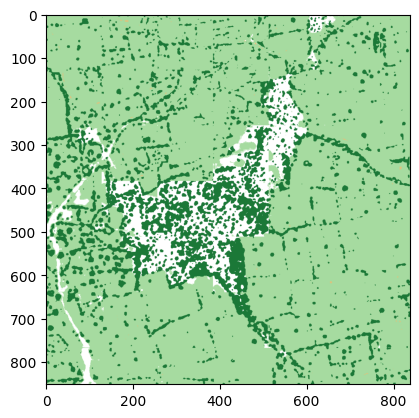

<Axes: >

In [ ]:

import rasterio
from rasterio.plot import show
tiff_img = rasterio.open('/content/drive/MyDrive/results/result_05.tif')
show(tiff_img)

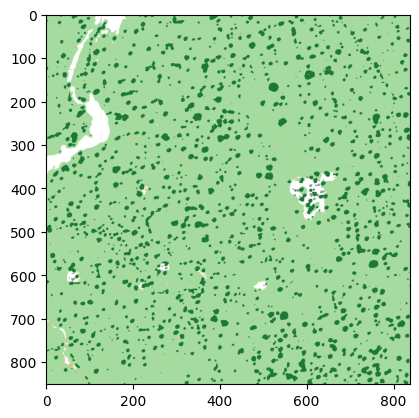

<Axes: >

In [ ]:
tiff_img = rasterio.open('/content/drive/MyDrive/results/result_06.tif')
show(tiff_img)

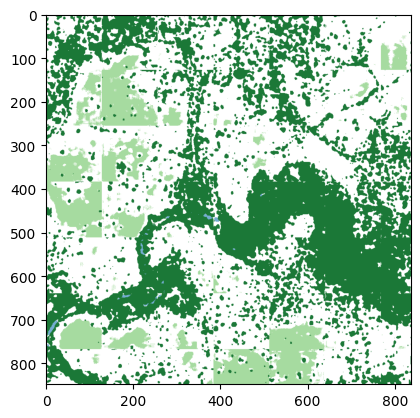

<Axes: >

In [ ]:
tiff_img = rasterio.open('/content/drive/MyDrive/results/result_08.tif')
show(tiff_img)